In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
tf.compat.v1.disable_eager_execution()

# Part 1: K-means

In [0]:
# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)


def distance(P1, P2): 
  diff=tf.subtract(P1, P2)
  return tf.norm(diff, ord='euclidean', axis=1)
  
# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions), N points, 2 dimensions
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    points = tf.expand_dims(X, 1)
    centroids = tf.expand_dims(MU, 0)

    return tf.reduce_sum( tf.square(tf.subtract(points, centroids)), 2)
    
    




In [0]:
print("hi")
with tf.Session() as sess:
  p1=tf.constant([[1, 2], [1, 1]], dtype="float16")
  p2=tf.constant([[0, 0], [1, 1], [-1, -1]], dtype="float16")

  g=distanceFunc(p1, p2)
  #print(g.eval())

hi


In [0]:
def buildGraph(dim, num_k, num_samples):

    X = tf.placeholder(tf.float32, shape=[None, dim])
    means = tf.Variable(tf.random.normal((num_k, dim), seed=421))
    clusters=tf.math.add(tf.argmin(distanceFunc(X, means), axis=1, output_type=tf.dtypes.int32), 1)
    percentages=tf.math.divide(tf.math.bincount(clusters, dtype=tf.dtypes.int32), num_samples)
    costfunction=tf.reduce_sum(tf.reduce_min(distanceFunc(X, means), axis=1))

    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=costfunction)
    return X, means, costfunction, train, percentages, clusters

In [0]:
def generatePlot(x_val, y_val, title, xlabel, ylabel, yupper):
    plt.figure(figsize=(8, 6))
   
    plt.plot(x_val,y_val)

    plt.ylim(0, yupper)    
    plt.legend(loc='upper right')        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
    

In [0]:
  def trainKmeans(data, K, epochs, val_data=None):   
    X, means, costfunction, train, percentages, clusters=buildGraph(data.shape[1], K, data.shape[0])
    loss=[]
    val_loss=[]
    finalpercentage=tf.placeholder(tf.float32)
    finalmeans=tf.placeholder(tf.float32)
    finalclusters=tf.placeholder(tf.float32)
    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
          _, err, m, p, c=sess.run([train, costfunction, means, percentages, clusters], feed_dict={X: data})
          if val_data is not None:
            val_err=sess.run([costfunction], feed_dict={X: val_data})

          loss.append(err)
          if val_data is not None:
            val_loss.append(val_err)
          finalpercentage=p
          finalmeans=m
          finalclusters=c
        
    return loss, finalpercentage, finalmeans, finalclusters, val_loss



No handles with labels found to put in legend.


[[-1.0559675  -3.2433348 ]
 [ 0.12191186 -1.5230945 ]
 [ 1.2517126   0.24657327]]


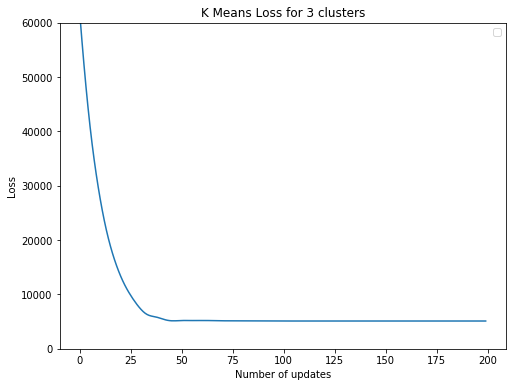

In [0]:
loss, percentages, means, clusters, _=trainKmeans(data, 3, 200)
print(means)
generatePlot(range(200), loss, "K Means Loss for 3 clusters", "Number of updates", "Loss", 60000)

In [0]:
def generate_plot(data, clusters, centers):
  fig, ax = plt.subplots(figsize=(8,6))
  x_val = [d[0] for d in data]
  y_val = [d[1] for d in data]
  scatter = ax.scatter(x_val, y_val, c=clusters, s=25)
  for i,j in centers:
      ax.scatter(i,j,s=1,c='red',marker='+')
  legend1 = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Clusters")
  
  K = max(clusters)
  plt.title("Scatter plots for %d cluster(s)" % (K) )
  plt.xlabel("x")
  plt.ylabel("y")   
  plt.show()

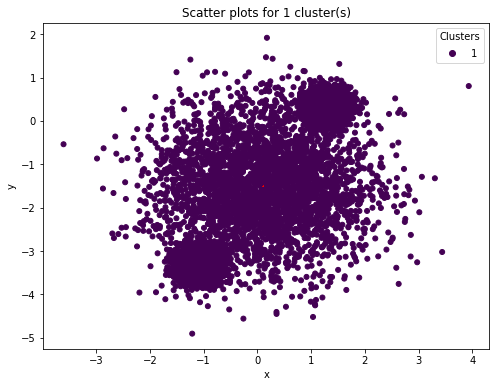

Points in cluster 1: 100.0%


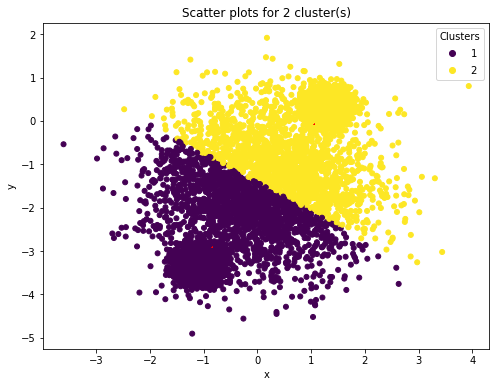

Points in cluster 1: 50.470000000000006%
Points in cluster 2: 49.53%


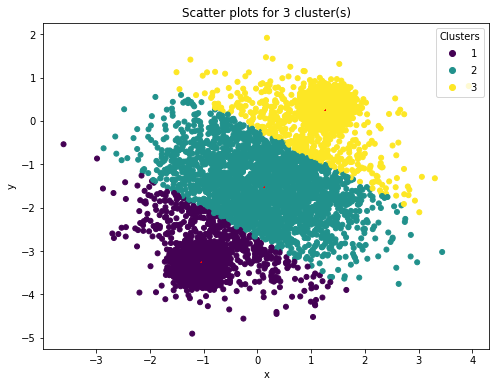

Points in cluster 1: 38.13%
Points in cluster 2: 23.810000000000002%
Points in cluster 3: 38.06%


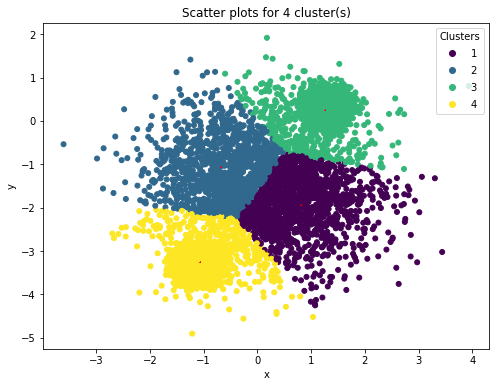

Points in cluster 1: 13.530000000000001%
Points in cluster 2: 12.030000000000001%
Points in cluster 3: 37.31%
Points in cluster 4: 37.13%


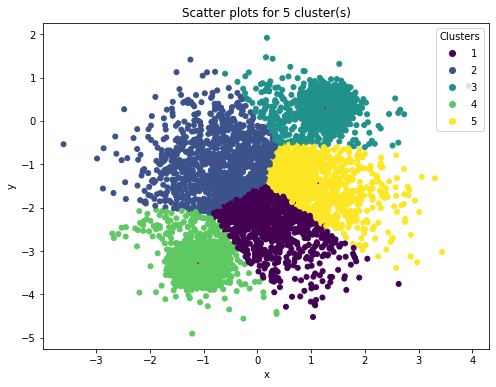

Points in cluster 1: 8.81%
Points in cluster 2: 10.77%
Points in cluster 3: 36.24%
Points in cluster 4: 35.760000000000005%
Points in cluster 5: 8.420000000000002%


In [0]:
for i in range(1, 6):
  loss, percentages, means, clusters, _=trainKmeans(data, i, 150)
  generate_plot(data, clusters, means)

  for j in range(1, percentages.shape[0]):
    print("Points in cluster "+str(j)+": "+str(percentages[j]*100)+"%")
    



No handles with labels found to put in legend.


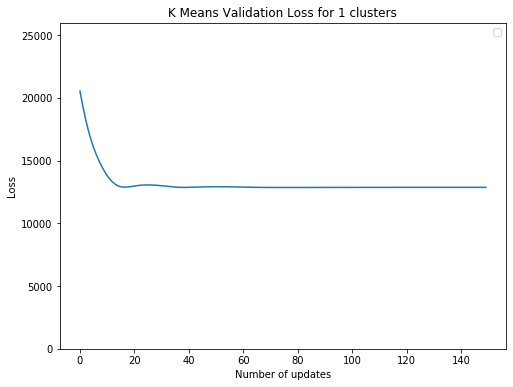

No handles with labels found to put in legend.


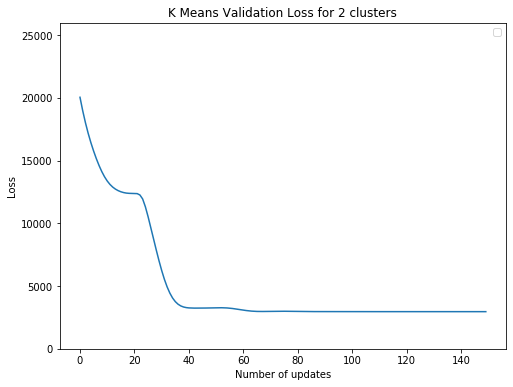

No handles with labels found to put in legend.


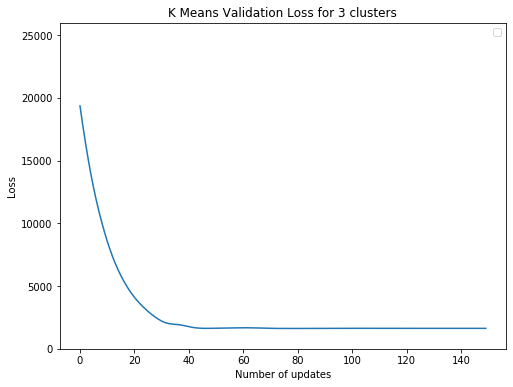

No handles with labels found to put in legend.


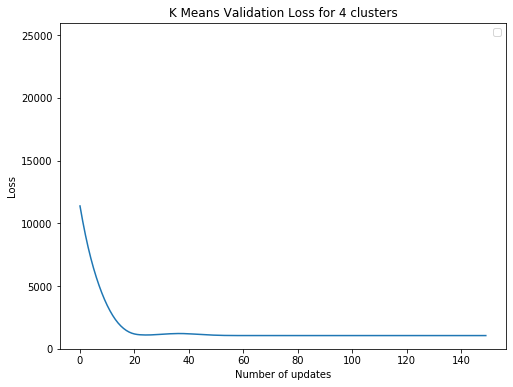

No handles with labels found to put in legend.


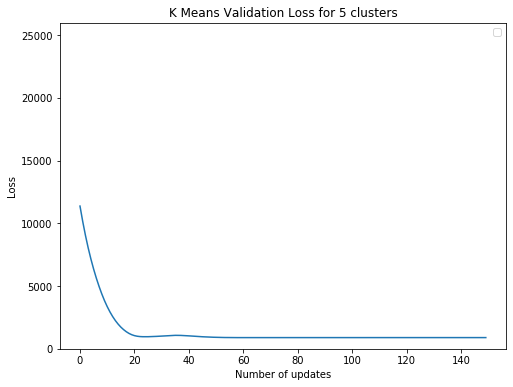

In [0]:
is_valid=True
# For Validation set
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

for i in range(1, 6):
  _, _, _, _, val_loss=trainKmeans(data, i, 150, val_data)
  generatePlot(range(150), val_loss, "K Means Validation Loss for "+str(i)+" clusters", "Number of updates", "Loss", 26000)


# Part 2: Mixture of Gaussians


## 2.1

In [0]:
import math

In [0]:
def data_retrieval(is_valid):
  # Loading data
  data = np.load('data2D.npy')
  # data = np.load('data100D.npy')
  [num_pts, dim] = np.shape(data)
  # For Validation set
  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    data = data[rnd_idx[valid_batch:]]
    return data, val_data
  
  return data




In [0]:
data = data_retrieval(False)

In [0]:
# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions), N points, 2 dimensions
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)

    points = tf.expand_dims(X, 1)
    centroids = tf.expand_dims(MU, 0) # This expansion will broadcast the matrices

    distances = tf.reduce_sum( tf.square(tf.subtract(points, centroids)), 2)

    return distances
    



In [0]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)


In [0]:
# Log Gauss PDF function for GMM
def log_GaussPDF(X, mu, sigma):
    distances = distanceFunc(X, mu)
    D = mu.get_shape().as_list()[1]

    var = tf.square(sigma) 
    term1 = -(D/2) * tf.log(2 * math.pi)
    term3 = -0.5 * tf.log(var) 
    term2 = -0.5 * tf.multiply(distances, tf.transpose(1/var))

    log_pdf = term2 + tf.transpose(term1 + term3)

    return log_pdf

In [0]:
with tf.Session() as sess:
  p1=tf.constant([[1, 2], [1, 1], [-1, -1]], dtype="float32")
  p2=tf.constant([[0, 0]], dtype="float32")
  p3=tf.constant([1], dtype="float32")
  g=log_GaussPDF(p1, p2, tf.transpose(p3))
  print(g.eval())


[[-4.3378773]
 [-2.837877 ]
 [-2.837877 ]]


In [0]:
def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    num = log_PDF + tf.transpose(log_pi) # log(pi * PDF) = log_pi + log_PDF
    den = reduce_logsumexp(num, 1, keep_dims=True)
    return num - den

In [0]:
with tf.Session() as sess:
  pi=tf.constant([[3]], dtype="float32")
  p1=tf.constant([[1, 2], [1, 1], [-1, -1]], dtype="float32")
  p2=tf.constant([[0, 0], [8, 8]], dtype="float32")
  p3=tf.constant([1], dtype="float32")
  g=log_GaussPDF(p1, p2, tf.transpose(p3))
  print(g.eval())
  print(log_posterior(g, tf.log(tf.transpose(pi))).eval())

[[ -4.3378773 -44.337875 ]
 [ -2.837877  -50.837875 ]
 [ -2.837877  -82.837875 ]]
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
[[  0.       -39.999996]
 [  0.       -47.999996]
 [  0.       -80.      ]]


In [0]:
# 2.2 MLE

In [0]:
def MLE(K, dim):
    X = tf.placeholder(tf.float32, shape=(None, dim))
    mu = tf.Variable(tf.truncated_normal((K, dim), seed=2))
    sigma = tf.Variable(tf.truncated_normal((K, 1), seed=2))
    phi = tf.exp(sigma)
    sigma_f = tf.log(phi)
    pi_init = tf.Variable(tf.ones((K,1)))
    log_pi = logsoftmax(pi_init)
    pi = tf.exp(log_pi)
    log_PDF = log_GaussPDF(X, mu, phi)

    # MLE
    param_gmm = log_PDF + tf.transpose(log_pi) # log(pi * PDF) = log_pi + log_PDF
    prob_x = reduce_logsumexp(param_gmm, 1, keep_dims=True)
    neg_mle = -1 * tf.reduce_sum(prob_x)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(neg_mle)

    # Cluster Associated
    log_post =  log_posterior(log_PDF, log_pi)
    cluster_associated = tf.argmax(log_post, 1)

    return X, mu, sigma_f, pi, train, neg_mle, cluster_associated



In [0]:
  def trainGMM(train_data, K, epochs, valid_data=None, is_valid=False, verbose=False):   
    X, mu, sigma, pi, train, neg_mle, cluster_associated = MLE(K, train_data.shape[1])
    loss_arr = []
    val_loss = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
          _, err, mean, var, pi_var, cluster = sess.run([train, neg_mle, mu, sigma, pi, cluster_associated], feed_dict={X: train_data})

          if verbose:
            print("----------------------------------------------")
            print("Epoch: " + str(e))
            print("Train Loss: " + str(err))
          loss_arr.append((e, err))
          
          if is_valid:
            val_err = sess.run([neg_mle], feed_dict={X: valid_data})
            val_loss.append((e, val_err))
            if verbose:
              print("Validation Loss: " + str(val_err))

    print("Final Train Loss: " + str(err))
    if is_valid:
      print("Final Validation Loss: " + str(val_err))
    
    return loss_arr, val_loss, mean, var, pi_var, cluster
        

In [0]:
loss_results, _, mean_final, var_final, pi_final, cluster_final = trainGMM(data, 3, 1500)

Final Train Loss: 25862.02


In [0]:
def generate_loss_plot_gmm(train_arr, val_arr=None, is_valid=False):
  plt.figure(figsize=(8, 6))

  x_train = [epoch[0] for epoch in train_arr]
  y_train = [epoch[1] for epoch in train_arr]
  plt.plot(x_train, y_train)

  if is_valid:
    x_val = [val[0] for val in val_arr]
    y_val = [val[1] for val in val_arr]
    plt.plot(x_val, y_val)

    
  plt.legend(['train', 'valid'], loc='upper right')        
  plt.title("Loss plots for train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")     
  plt.show()   

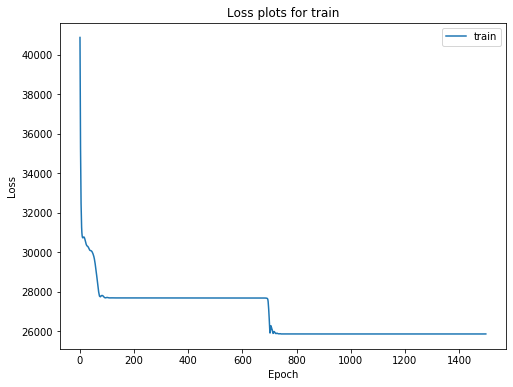

In [0]:
generate_loss_plot_gmm(loss_results)

In [0]:
def generate_scatter_plot_gmm(data, clusters, centers, K):
  fig, ax = plt.subplots(figsize=(8,6))
  x_val = [d[0] for d in data]
  y_val = [d[1] for d in data]
  scatter = ax.scatter(x_val, y_val, c=clusters, s=10)
  for i,j in centers:
      ax.scatter(i,j,s=50,c='red',marker='+')   
  legend1 = ax.legend(*scatter.legend_elements(),
                      loc="upper right", title="Clusters")

  plt.title("Scatter plots for %d cluster(s)" % (K) )
  plt.xlabel("x")
  plt.ylabel("y") 
  plt.show()

In [0]:
pi_final

array([[0.4284436 ],
       [0.28616714],
       [0.28538918]], dtype=float32)

In [0]:
var_final

array([[ 0.47103205],
       [-1.3009422 ],
       [-1.3013546 ]], dtype=float32)

In [0]:
mean_final

array([[ 0.10046078, -1.5239956 ],
       [ 1.3040874 ,  0.31033912],
       [-1.1150497 , -3.3087916 ]], dtype=float32)

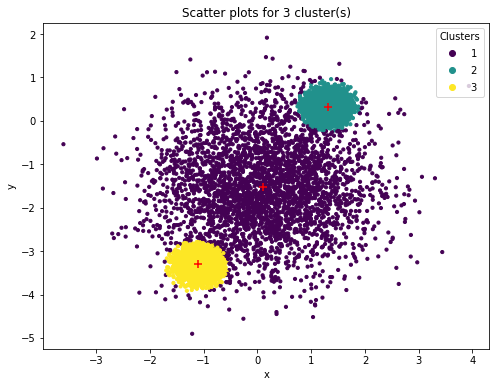

In [0]:
generate_scatter_plot_gmm(data, cluster_final + 1, mean_final, 3)

## 2.2

In [0]:
def train_validate(train_data, valid_data, K, epochs, is_valid=False):
  if not is_valid:
    loss_results, _, mean_final, var_final, pi_final, cluster_final = trainGMM(train_data, K, epochs)
    generate_loss_plot_gmm(loss_results)
    generate_scatter_plot_gmm(train_data, cluster_final + 1, mean_final, K)
  else:
    loss_results, val_loss, mean_final, var_final, pi_final, cluster_final = trainGMM(train_data, K, epochs, valid_data, True)
    generate_loss_plot_gmm(loss_results, val_loss, True)
    generate_scatter_plot_gmm(train_data, cluster_final + 1, mean_final, K)
    print(mean_final)


In [0]:
t_data, v_data = data_retrieval(True)

Final Train Loss: 20070.18
Final Validation Loss: [10043.352]


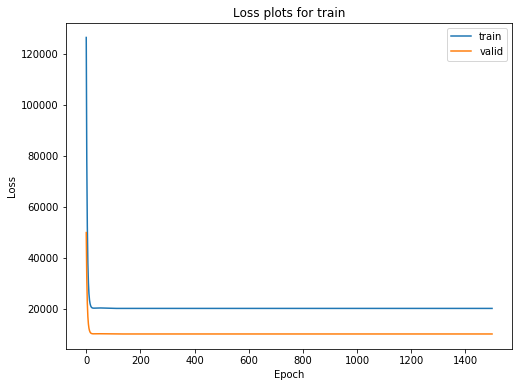

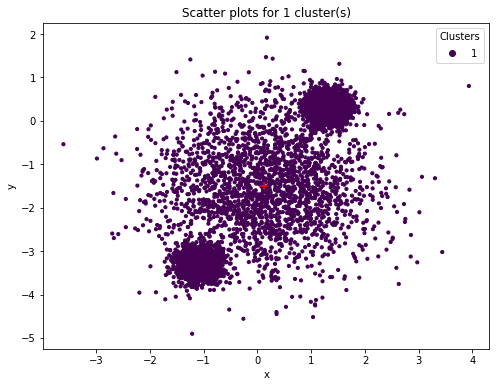

[[ 0.1190101 -1.4958047]]
Final Train Loss: 18478.73
Final Validation Loss: [9209.329]


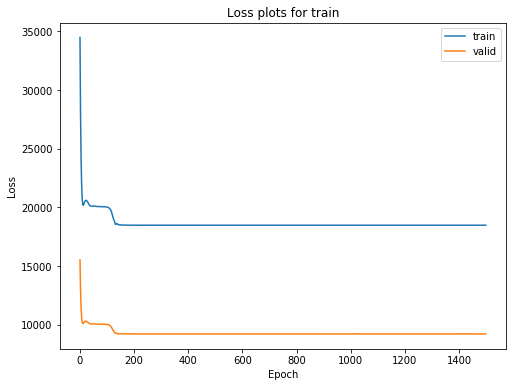

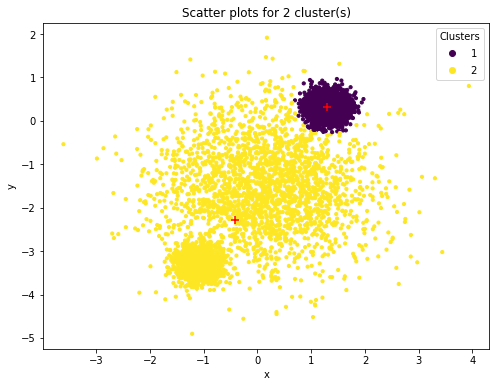

[[ 1.3007327   0.3134606 ]
 [-0.41075358 -2.2937102 ]]
Final Train Loss: 17278.254
Final Validation Loss: [8585.451]


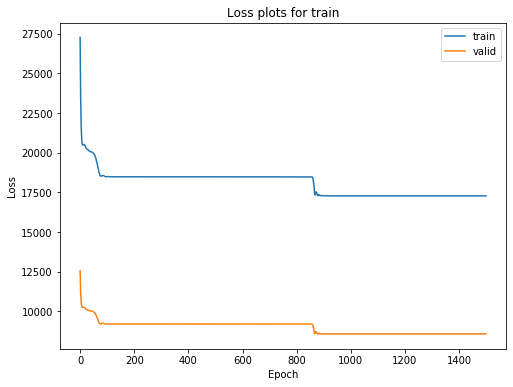

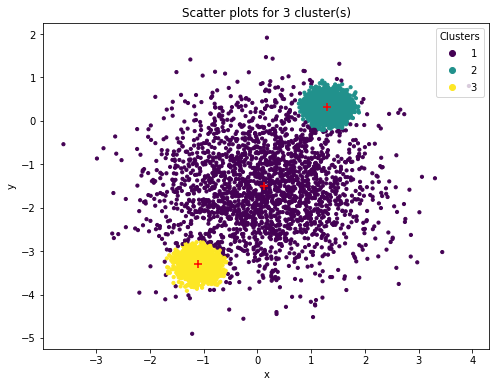

[[ 0.11961465 -1.5062528 ]
 [ 1.300227    0.3107945 ]
 [-1.110101   -3.3040235 ]]
Final Train Loss: 17278.145
Final Validation Loss: [8584.499]


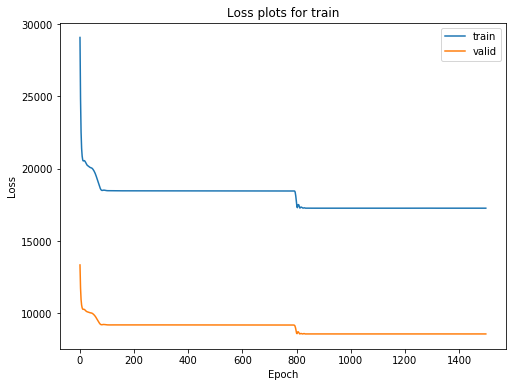

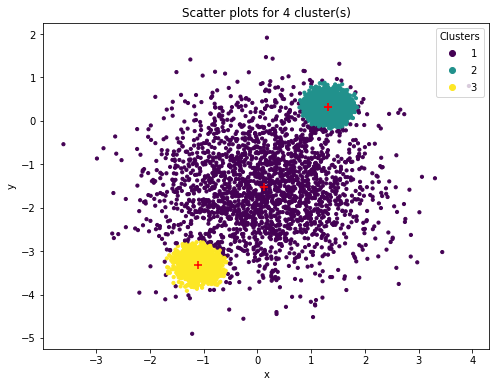

[[ 0.12007136 -1.513353  ]
 [ 1.3060962   0.31354764]
 [-1.1051415  -3.3110716 ]
 [ 1.3060957   0.31354713]]
Final Train Loss: 17278.049
Final Validation Loss: [8584.9795]


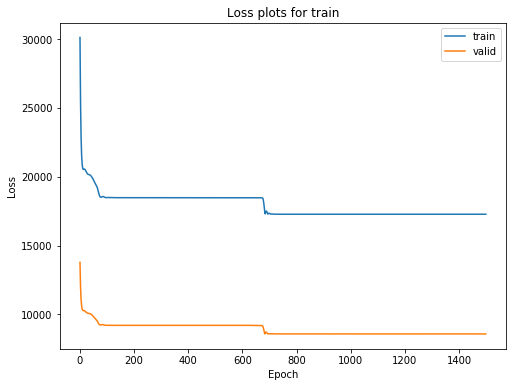

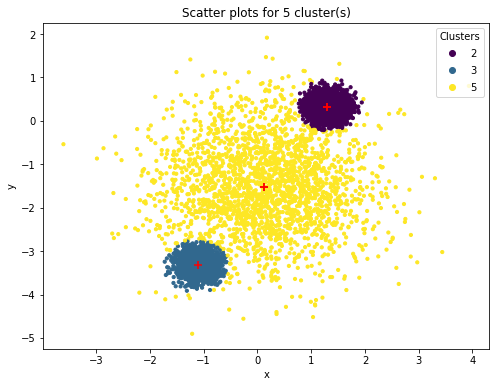

[[ 0.12330617 -1.5145494 ]
 [ 1.2970473   0.30963853]
 [-1.1088866  -3.3142307 ]
 [ 1.2970434   0.30963504]
 [ 0.12330768 -1.5145593 ]]


In [0]:
for i in range(1, 6):
  train_validate(t_data, v_data, i, 1500, True)

## 2.3

In [0]:
def data_100():
  # Loading data
  data = np.load('data100D.npy')
  # data = np.load('data100D.npy')
  [num_pts, dim] = np.shape(data)
  # For Validation set
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]
  return data, val_data

In [0]:
t_data, v_data = data_100()

In [0]:
def kmeans_100(data, val_data, k, epoch):
  loss, finalpercentage, finalmeans, finalclusters, val_loss = trainKmeans(data, k, epoch, val_data)
  print("---------------------------------------------------------")
  print("K = " + str(k))
  print("\n K Means")
  print("Final Train Loss: " + str(loss[-1]))
  print("Final Validation Loss: " + str(val_loss[-1]))

In [0]:
def GMM_100(train_data, valid_data, K, epochs):
  loss_results, val_loss, mean_final, var_final, pi_final, cluster_final = trainGMM(train_data, K, epochs, valid_data, True)

In [0]:
K_trials = [5, 10, 15, 20, 30]
for i in K_trials:
  kmeans_100(t_data, v_data, i, 1500) # K means
  print("\n GMM: ")
  GMM_100(t_data, v_data, i, 1500)

---------------------------------------------------------
K = 5

 K Means
Final Train Loss: 143516.75
Final Validation Loss: [71797.26]

 GMM: 
Final Train Loss: 631347.0
Final Validation Loss: [315617.7]
---------------------------------------------------------
K = 10

 K Means
Final Train Loss: 139785.92
Final Validation Loss: [70155.78]

 GMM: 
